# Smart To-Do List Optimizer with Reinforcement Learning

This notebook implements a task optimization system using LangGraph and LLMs to organize, categorize, prioritize, and schedule tasks intelligently.

In [41]:
from datetime import datetime
from typing import Dict, List, Optional, Union, Literal
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq

## Type Definitions

Define the structure for our tasks and agent state.

In [42]:
# Type definitions for our state
class Task(TypedDict):
    title: str
    category: Optional[str]
    priority: Optional[str]
    status: str
    deadline: Optional[str]
    scheduled_time: Optional[str]
    reasoning: Optional[str]


class ModelReward(TypedDict):
    threshold: float
    overall_comment: str

class AgentState(TypedDict):
    previous_tasks: List[Task]
    current_tasks: List[Task]
    optimized_tasks: List[Task]
    feedback: Optional[str]
    reward: ModelReward

## LLM Initialization

Setup the language model for task optimization.

In [43]:
# Initialize the LLM
def task_optimizer():
    # Replace with your preferred LLM service
    llm = ChatGroq(
        model="llama-3.3-70b-versatile",  # You can substitute with other models
        temperature=0.9
    )
    # Create prompt
    chat_history = [("system", SYSTEM_PROMPT), MessagesPlaceholder(variable_name="messages")] # [("human", TASK_PROCESSING_PROMPT), ("ai", "'sd;fsdjfsdf;")
    prompt = ChatPromptTemplate.from_messages(chat_history)
    optimizer = prompt | llm 
    return optimizer

## Prompt Templates

Define the system and task processing prompts.

In [44]:
# Prompts for the agent
SYSTEM_PROMPT = """You are a Smart To-Do List Assistant. Your role is to help users manage their workflow efficiently by organizing, categorizing, prioritizing, and scheduling their tasks. When a user provides a list of tasks, you should:
- Review previously completed and ongoing tasks to understand context and dependencies.
- Organize new tasks into relevant categories (e.g., Work, Personal, Health, Finance, Errands).
- Assess each task's urgency, deadlines, and overall impact on the user's workflow.
- Prioritize and sort the tasks based on their level of importance, ensuring that the most critical tasks are highlighted.
- Ensure that deadlines are considered when arranging the tasks to maximize productivity.
- Suggest the best **day and time** for each task to be executed based on urgency, workload, and logical order.
- Explain **why** each scheduling decision was made, providing a brief rationale.

Your output should be JSON-formatted task objects with these fields:
- title: The task title
- category: The category you've assigned
- priority: Priority level (High, Medium, Low)
- status: Current status
- deadline: Due date if applicable
- scheduled_time: Your recommended day and time
- reasoning: Brief explanation for your scheduling decision
"""

TASK_PROCESSING_PROMPT = """
Given the following information, optimize the to-do list by categorizing, prioritizing, and scheduling the tasks:

Previous Tasks:
{previous_tasks}

Current Tasks:
{current_tasks}

Today's date: {current_date}

Return ONLY a valid JSON array of task objects with the following structure:
[
    {{
        "title": "Task title",
        "category": "Category",
        "priority": "Priority level",
        "status": "Status",
        "deadline": "Deadline if applicable",
        "scheduled_time": "Suggested day and time",
        "reasoning": "Brief explanation for scheduling"
    }}
]
"""

## Node Functions

Define the functions that make up our reinforcement learning graph.

In [45]:
# Node functions
def process_tasks(state: AgentState) -> AgentState:
    """Process the current tasks and generate an optimized to-do list"""
    # Format tasks for prompt
    previous_tasks_str = format_tasks_for_prompt(state["previous_tasks"])
    current_tasks_str = format_tasks_for_prompt(state["current_tasks"])

    request = HumanMessage(
        content=TASK_PROCESSING_PROMPT.format(
            previous_tasks=previous_tasks_str,
            current_tasks=current_tasks_str,
            current_date=datetime.now().strftime("%Y-%m-%d")
        )
    )

    # Get response from LLM
    response = task_optimizer().invoke({"messages": [request]})
    response_text = response.content

    # Extract JSON from response
    import json
    import re

    # Look for JSON array in the response
    json_match = re.search(r'\[(.*?)\]', response_text, re.DOTALL)
    if json_match:
        try:
            optimized_tasks = json.loads("[" + json_match.group(1) + "]")
            state["optimized_tasks"] = optimized_tasks
        except json.JSONDecodeError:
            # Fallback if JSON extraction fails
            state["optimized_tasks"] = []
            state["feedback"] = "Failed to parse optimized tasks"
    else:
        state["optimized_tasks"] = []
        state["feedback"] = "No valid task list found in response"

    return state

In [46]:
def evaluate_optimization(state: AgentState) -> AgentState:
    """Evaluate the quality of the optimization and assign a reward"""
    print("Staring evaluation")
    reward = 0.0

    if not state["optimized_tasks"]:
        state["reward"] = ModelReward(threshold=0.0, overall_comment="")
        return state

    # Reward for complete processing (all tasks have been scheduled)
    if len(state["optimized_tasks"]) >= len(state["current_tasks"]):
        reward += 1.0
        print("Model rewarded because it all tasks have been scheduled")
    else:
        reward -= 1.0

    # Check for categorization
    categories_assigned = all("category" in task and task["category"] for task in state["optimized_tasks"])
    if categories_assigned:
        reward += 1.0
        print("Model rewarded because it categorized the task")
    else:
        reward -= 1.0

    # Check for prioritization
    priorities_assigned = all("priority" in task and task["priority"] for task in state["optimized_tasks"])
    if priorities_assigned:
        reward += 1.0
        print("Model rewarded because it prioritized the task")
    else:
        reward -= 1.0

    # Check for scheduling
    times_assigned = all("scheduled_time" in task and task["scheduled_time"] for task in state["optimized_tasks"])
    if times_assigned:
        reward += 1.0
        print("Model rewarded because it scheduled the task")
    else:
        reward -= 1.0

    # Check for reasoning
    reasoning_provided = all("reasoning" in task and task["reasoning"] for task in state["optimized_tasks"])
    if reasoning_provided:
        reward += 1.0
        print("Model rewarded because it optimized task with a reason")
    else:
        reward -= 1.0

    # Check for deadline consideration
    deadline_tasks = [task for task in state["current_tasks"] if "deadline" in task and task["deadline"]]
    if deadline_tasks:
        # Simple check that higher priority is given to tasks with closer deadlines
        # (This is a simplification - real deadline checking would be more complex)
        high_priority_tasks = [task for task in state["optimized_tasks"]
                               if "priority" in task and task["priority"] == "High"]
        deadline_consideration = any(task["title"] in [t["title"] for t in deadline_tasks]
                                     for task in high_priority_tasks)
        if deadline_consideration:
            reward += 1.0
        else: 
             reward -= 1.0
        print("Model rewarded because it optimized task")
        
            
            
    print(f"Finished evaluation. Total reward: {reward}")
    

    state["reward"] = ModelReward(threshold=reward, overall_comment="NOT GOOD")
    return state

In [47]:
def format_output(state: AgentState) -> AgentState:
    """Format the optimized to-do list for user presentation"""
    if not state["optimized_tasks"]:
        state["feedback"] = "Unable to generate an optimized to-do list."
        return state

    output = ["# Optimized To-Do List\n"]

    # Group tasks by category
    tasks_by_category = {}
    for task in state["optimized_tasks"]:
        category = task.get("category", "Uncategorized")
        if category not in tasks_by_category:
            tasks_by_category[category] = []
        tasks_by_category[category].append(task)

    # Format by category
    for category, tasks in tasks_by_category.items():
        output.append(f"## {category}")

        # Sort tasks by priority within category
        priority_order = {"High": 0, "Medium": 1, "Low": 2}
        sorted_tasks = sorted(tasks, key=lambda x: priority_order.get(x.get("priority", "Low"), 3))

        for task in sorted_tasks:
            priority_indicator = "🔴" if task.get("priority") == "High" else "🟠" if task.get(
                "priority") == "Medium" else "🟢"
            output.append(f"{priority_indicator} **{task['title']}**")
            output.append(f"   📅 {task.get('scheduled_time', 'No time specified')}")
            if "deadline" in task and task["deadline"]:
                output.append(f"   ⏰ Deadline: {task['deadline']}")
            output.append(f"   💡 {task.get('reasoning', 'No reasoning provided')}")
            output.append("")

    state["feedback"] = "\n".join(output)
    return state

In [48]:
def format_tasks_for_prompt(tasks: List[Task]) -> str:
    """Format tasks for inclusion in prompts"""
    if not tasks:
        return "No tasks available."

    result = []
    for task in tasks:
        task_str = f"- {task.get('title', 'Untitled Task')}"

        # Add category if available
        if "category" in task and task["category"]:
            task_str += f" - {task['category']}"

        # Add priority if available
        if "priority" in task and task["priority"]:
            task_str += f" - {task['priority']}"

        # Add status
        task_str += f" - {task.get('status', 'Not Started')}"

        # Add deadline if available
        if "deadline" in task and task["deadline"]:
            task_str += f" - {task['deadline']}"

        result.append(task_str)
    
    return "\n".join(result)

In [49]:
def should_reprocess(state: AgentState) -> Union[Literal["reprocess"], Literal["output"]]:
    """Decide whether to reprocess the optimization based on reward"""
    # If the reward is too low, reprocess
    if state["reward"].get("threshold") < 5.0:  # Threshold for acceptable optimization
        return "reprocess"
    return "output"

## Graph Creation

Create the reinforcement learning graph for the to-do list optimizer.

In [50]:
# Create the graph
def create_todo_rl_graph():
    """Create the StateGraph for the to-do list RL agent"""
    workflow = StateGraph(AgentState)

    # Add nodes to the graph
    workflow.add_node("process_tasks", process_tasks)
    workflow.add_node("evaluate", evaluate_optimization)
    workflow.add_node("format_output", format_output)

    # Define edges
    workflow.add_edge("process_tasks", "evaluate")
    workflow.add_conditional_edges(
        "evaluate",
        should_reprocess,
        {
            "reprocess": "process_tasks",
            "output": "format_output"
        }
    )
    workflow.add_edge("format_output", END)

    # Set the entry point
    workflow.set_entry_point("process_tasks")

    return workflow.compile()

## Running the Agent

Function to run the to-do list reinforcement learning agent with provided tasks.

In [51]:
# Example usage
def run_todo_rl_agent(previous_tasks: List[Dict], current_tasks: List[Dict]) -> str:
    """Run the to-do list RL agent with the given tasks"""
    # Initialize the state
    initial_state = AgentState(
        previous_tasks=previous_tasks,
        current_tasks=current_tasks,
        optimized_tasks=[],
        feedback=None,
        reward=ModelReward(threshold=0.0, overall_comment=""),
    )
    
    # Create and run the graph i.e our RL agent
    todo_list_rl_agent = create_todo_rl_graph()

    # Display the agent
    from IPython.display import Image, display

    try:
        display(Image(todo_list_rl_agent.get_graph(xray=True).draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print("Could not display graph visualization:")
        print(e)
        pass
    final_state = todo_list_rl_agent.invoke(initial_state)

    return final_state["feedback"]

## Example Data and Execution

Try the to-do list optimizer with example tasks.

In [52]:
# Example data
# Previously completed or ongoing tasks
previous_tasks = [
    {
        "title": "Weekly team meeting",
        "category": "Work",
        "priority": "High",
        "status": "Not Started"
    },
    {
        "title": "Grocery shopping",
        "category": "Errands",
        "priority": "Medium",
        "status": "Completed"
    },
    {
        "title": "Update project documentation",
        "category": "Work",
        "priority": "High",
        "status": "In Progress"
    }
]

# New tasks that need optimization
current_tasks = [
    {
        "title": "Prepare quarterly report",
        "status": "Not Started",
        "deadline": "2025-03-05"
    },
    {
        "title": "Call dentist for appointment",
        "status": "Not Started",
        "deadline": "2025-02-28"
    },
    {
        "title": "Fix kitchen sink",
        "status": "Not Started"
    },
    {
        "title": "Review project proposal",
        "status": "Not Started",
        "deadline": "2025-02-26"
    },
    {
        "title": "Attend online workshop",
        "status": "Not Started",
        "deadline": "2025-03-01"
    }
]

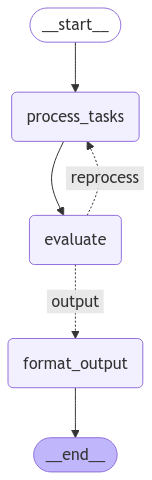

Staring evaluation
Model rewarded because it all tasks have been scheduled
Model rewarded because it categorized the task
Model rewarded because it prioritized the task
Model rewarded because it scheduled the task
Model rewarded because it optimized task with a reason
Model rewarded because it optimized task
Finished evaluation. Total reward: 6.0
# Optimized To-Do List

## Work
🔴 **Review project proposal**
   📅 2025-02-26 09:00
   ⏰ Deadline: 2025-02-26
   💡 Today is the deadline for the task, so it's essential to complete it as soon as possible to meet the deadline.

🔴 **Prepare quarterly report**
   📅 2025-03-03 09:00
   ⏰ Deadline: 2025-03-05
   💡 The task has a deadline in a few days, but it's not as urgent as the review project proposal or call dentist for appointment, so it's scheduled for a few days later to allow for a reasonable amount of time to complete other tasks.

🟠 **Attend online workshop**
   📅 2025-03-01 09:00
   ⏰ Deadline: 2025-03-01
   💡 The task is scheduled for 

In [53]:
# Run the agent
result = run_todo_rl_agent(previous_tasks, current_tasks)
print(result)